# Logistic Regression for Prediction

### Learning Goals
You will be able to:

1. Identify problems that can be solved using logistic regression
2. Define the output space of a logistic regression
3. Use sklearn to build and evaluate a logistic regression model

### When would we use logistic regression?

Logistic regression is useful for classification problems. This means that from our data we want to predict some sort of category.

For example, if we wanted to predict:
    - Default or not Default on a loan
    - Rain or No Rain tomorrow
    
**Pair up and come up with 2-3 specific examples of problems that we could try solve using logistic regression.**

### Quick Linear Regression Review

In previous lectures we learned about linear regression where the model followed the form of: $$\hat{y} = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n$$ 

where:
* $\hat{y}$ is our prediction

* x are the values of the features

* $\beta$ are the coefficients.

The outputs from the a linear regression model can take on any real value, but in the case of a binary classification the only outputs are either 0 or 1.

How might we transform the output of our model in order to constrain the values to a reasonable range?

### The logistic function

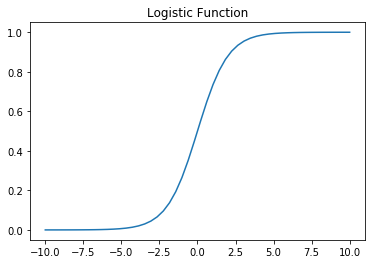

In [64]:
import scipy.stats as scs
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))

x = np.linspace(-10, 10)
ax.plot(x, scs.logistic.cdf(x))
ax.set_title('Logistic Function');

The logistic function:

$$f(x) = \frac{1}{1 + e^{-x}}$$

We can use the logistic function to squash all of our values between 0 and 1. Looking at the graph we see that very large values of x are pushed closer and closer to 1 while very negative values approach 0. This type of behavior has a natural interpretation as the probability of any particular observation being in the positive class. 

To make the connection to linear regression a bit more clear we can substitute in our linear model into the logistic function like so:

$$predicted probability = \frac{1}{1 + e^{-\beta_0 + \beta_1 x_1 + ... + \beta_n x_n}}$$

**In summary, logistic regression maps the "real line" output from linear regression to the probability space of [0,1]**

## Optimization

#### Logistic Regression Cost Function: Log Loss

$$Log Loss = -\frac{1}{m}\sum_{i=1}^m [y^{(i)}log(\hat{p}^{(i)}) + (1 - y^{(i)})log(1 - \hat{p}^{(i)})]  $$

This equation can look a bit intimidating but lets take a minute to break this down and understand what its trying to do.

Lets think about an observation that is in the positive class, 1 and we predict a high probability.

What happens when we predict a low probability?

Now think about the opposite cases where an observation is in the negative class, 0 and we predict a high or low probability.

#### Gradient Descent

There is no known closed form solution to find the values of $\beta$ which minimize log loss so instead we can use gradient descent to find optimal values for $\beta$

## Toy Example

In [148]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.datasets import make_classification

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

In [137]:
X_fake, y_fake = make_classification(n_samples=50,
                                     n_features=1,
                                     n_informative=1,
                                     n_redundant=0,
                                     n_clusters_per_class=1,
                                     random_state=0)

In [138]:
lr_fake = LogisticRegression(penalty='none')
lr.fit(X_fake, y_fake)

preds_fake = lr.predict_proba(X_fake)[:, 1] #what does predict proba return?

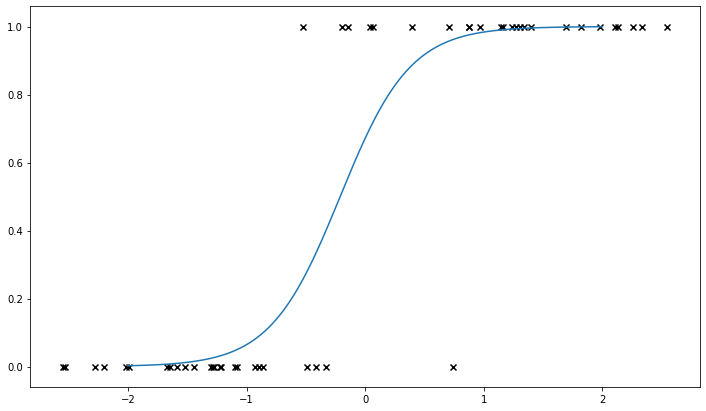

In [139]:
fig, ax = plt.subplots(figsize=(12, 7))
x = np.linspace(-2, 2, num=1000)

ax.plot(x, lr.predict_proba(x.reshape(-1, 1))[:, 1])

ax.scatter(X_fake, y_fake, marker='x', color='black');

## A Full Logistic Regression Workflow

In [7]:
df = pd.read_csv('data/bank.csv', sep=';')

Lets create a simple model using just a few of the available features.

In [10]:
features = ['age', 'job', 'education']

X = df.loc[:, features]
y = df.loc[:, 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### What kind of preprocessing do we need to do before we pass in our data to the logisitic regression model?

In [17]:
X_train.head()

,age,job,education
292,53,services,secondary
1509,42,admin.,secondary
1895,29,services,secondary
1504,47,admin.,secondary
1946,42,services,secondary


### Preprocessing categorical variables

In [74]:
#specify categorical features
categoricals = ['job', 'education']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values

#combine continuous and categorical data

X_train_preprocessed = pd.concat([X_train.loc[:, 'age'], X_train_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)

# X_train_preprocessed

In [78]:
#transform testing set
cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #remember to only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_test.index) #keep the same index values

X_test_preprocessed = pd.concat([X_test.loc[:, 'age'], X_test_ohe], axis=1)
X_test_preprocessed = ss.transform(X_test_preprocessed)


### Create Logistic Regression Model

There is one main gotcha when using sklearn's logistic regression implementation. There is always some amount of regularization applied by default so if you want an unbiased estimate you need to explicitly define the penalty to be none.

This might lead to problems if your groups are perfectly seperable but in most cases it shouldn't be a problem. 

In [140]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_preprocessed, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Model Evaluation

Now that we have fit our model we need to evaluate how well it has done.

So far we have only predicted probabilites but now we have to think about how we will go from strict probabilities to predicting class membership.

A naive solution to predicting class membership would be to simply predict every observation that has over a 50% probability of being in the positive class, as being in the positive class. For all other observations we will predict membership in the negative class.

This naive solution is the default behavior for sklearn if we use the predict method. Lets stick with this decision rule for now and then complicate are thinking after we look at some tools to understand classification models.

### Confusion Matrix

False Positve

False Negative

Accuracy

Precision

Recall

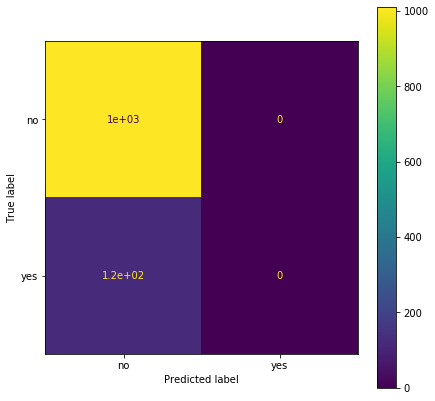

In [152]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_test_preprocessed, y_test, ax=ax);

### ROC Curve

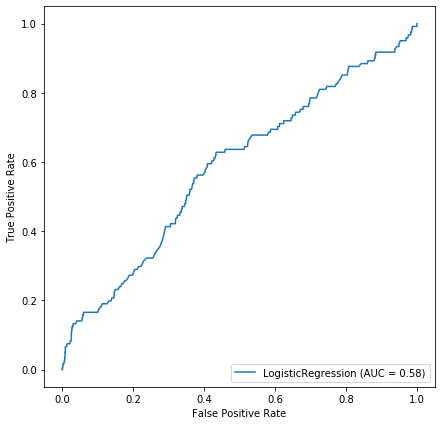

In [151]:
fig, ax = plt.subplots(figsize=(7, 7))

plot_roc_curve(lr, X_test_preprocessed, y_test, ax=ax);